C:\Temp\ipykernel_4744\1954654704.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


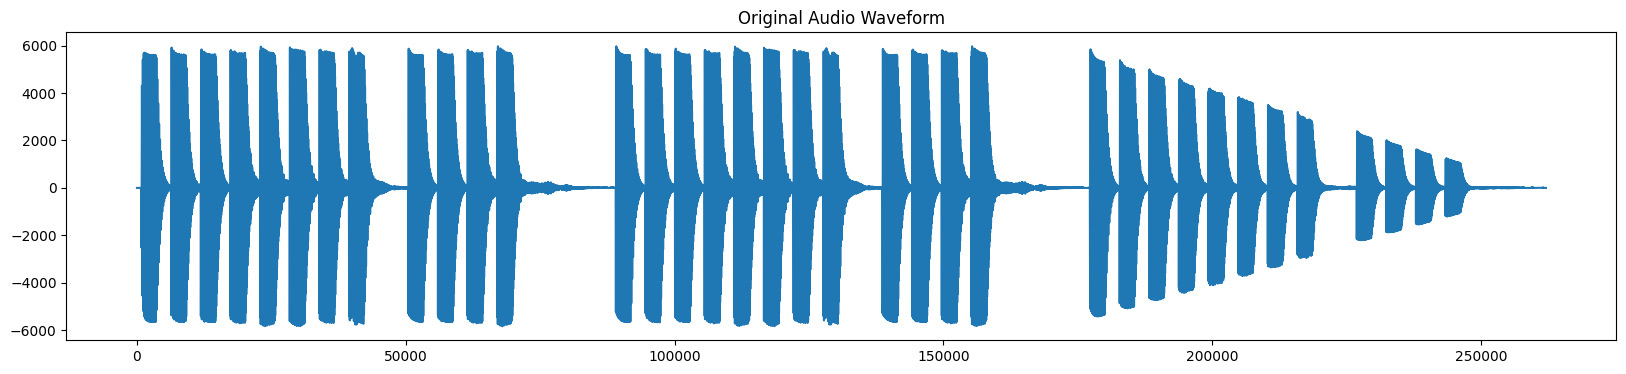

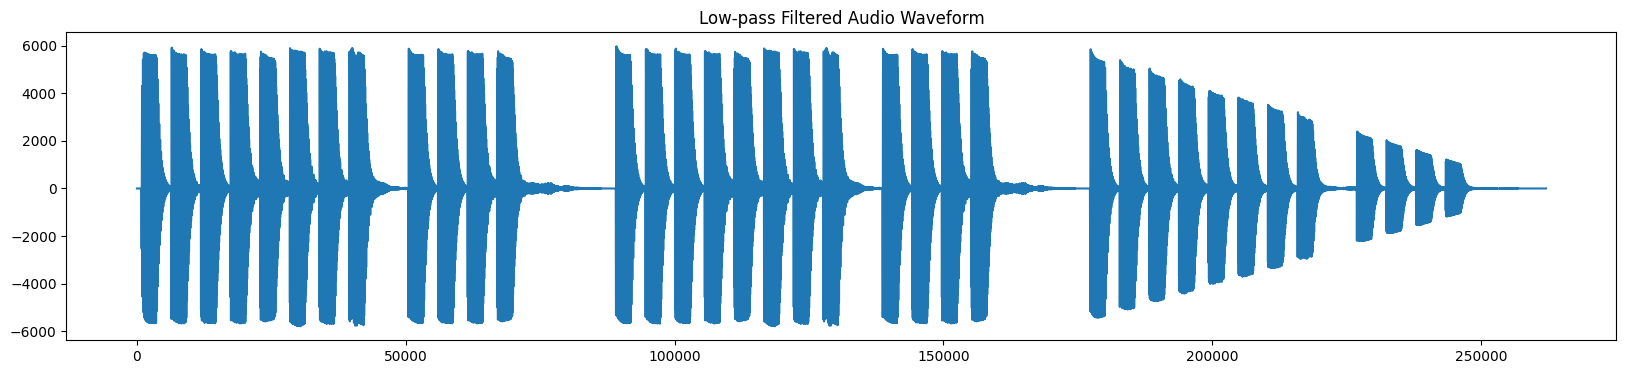

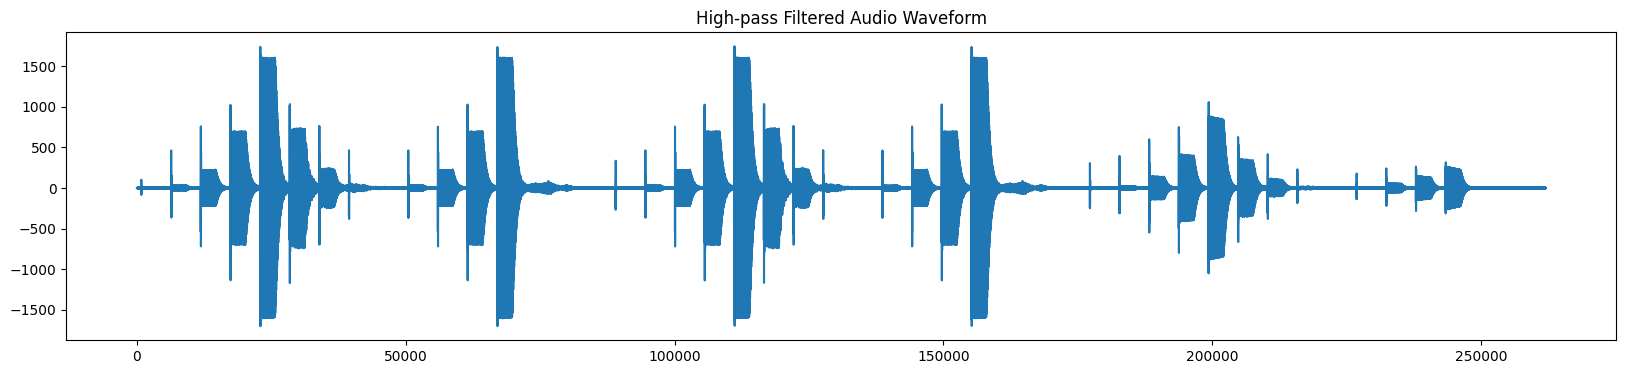

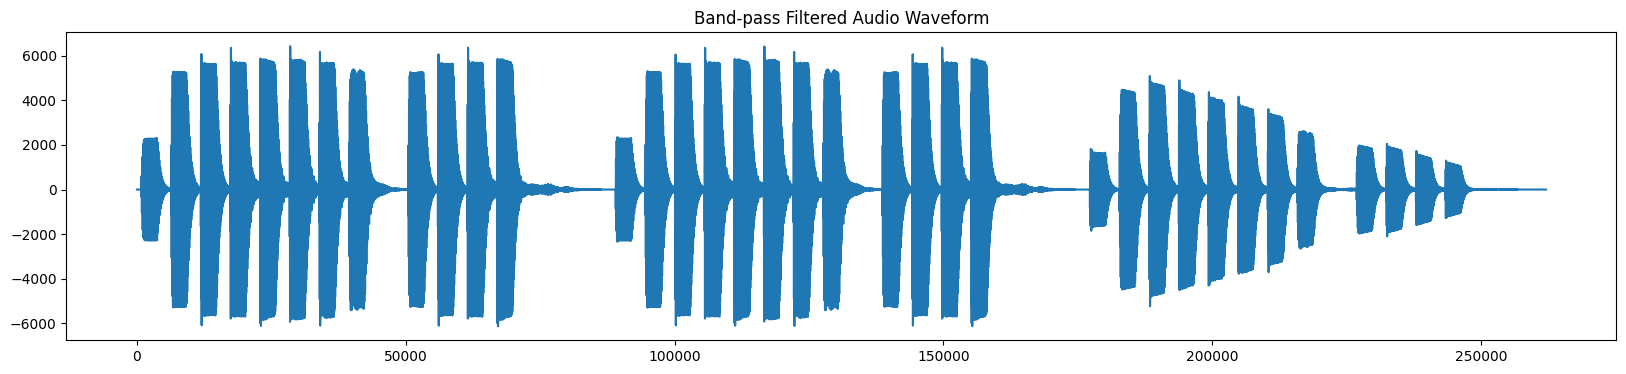

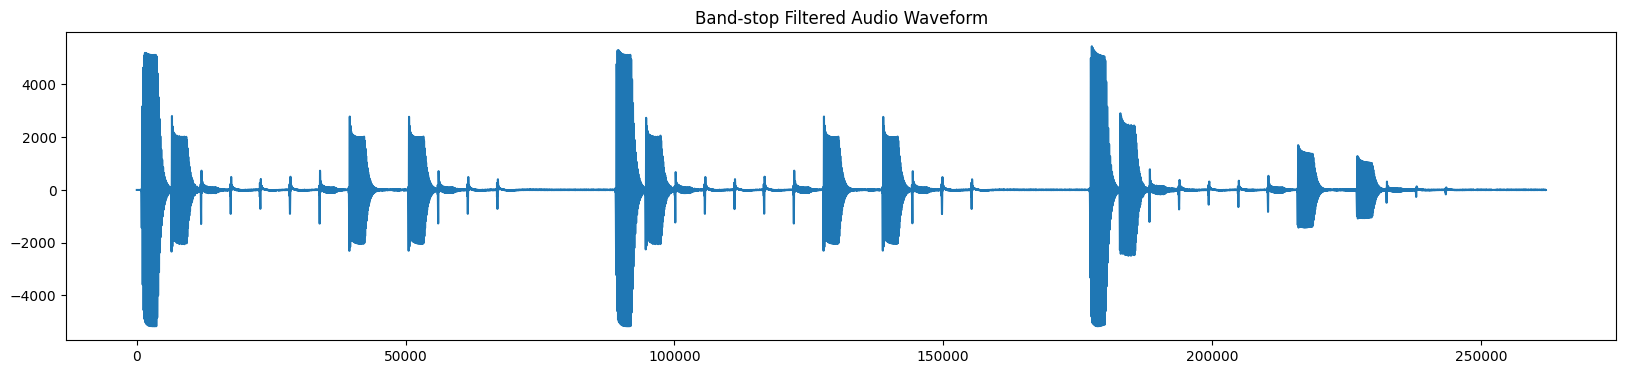

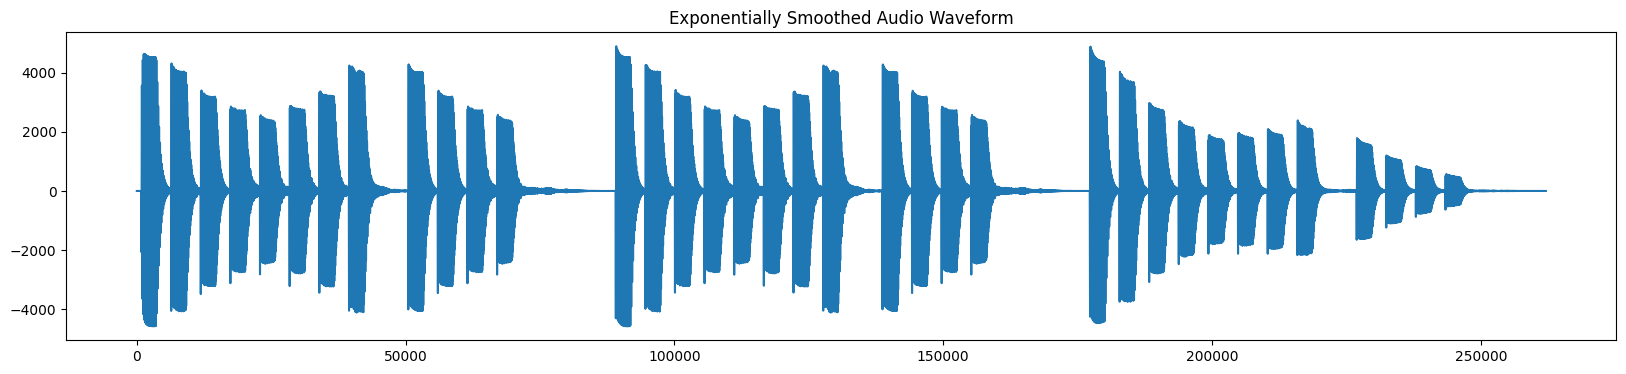

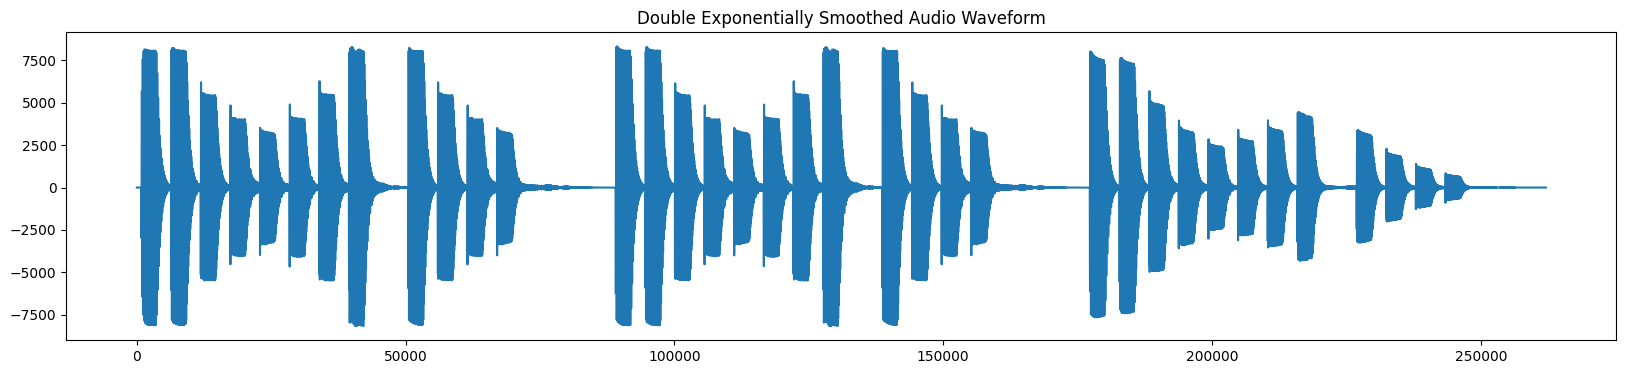

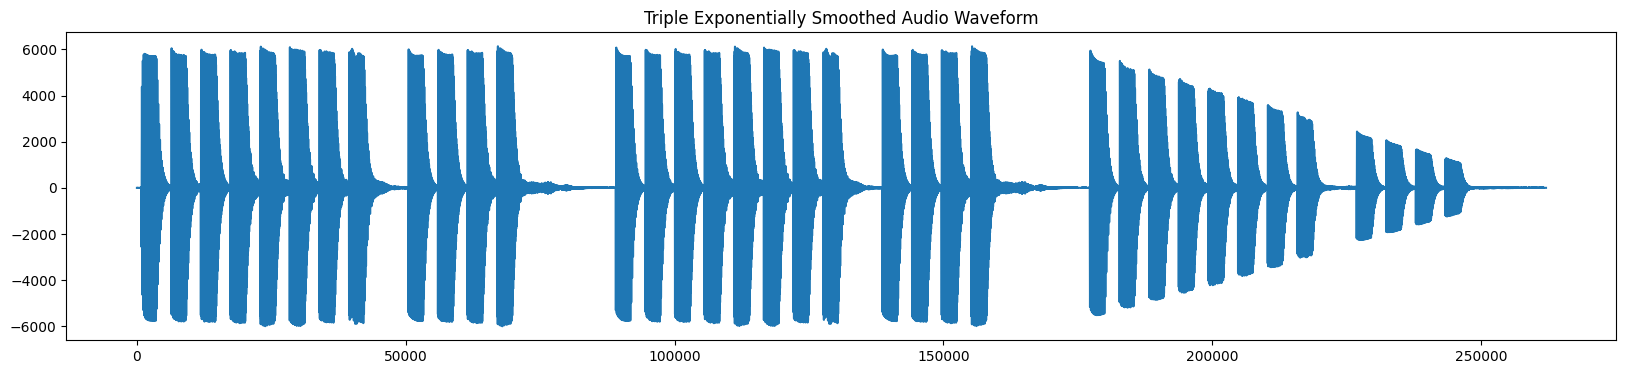

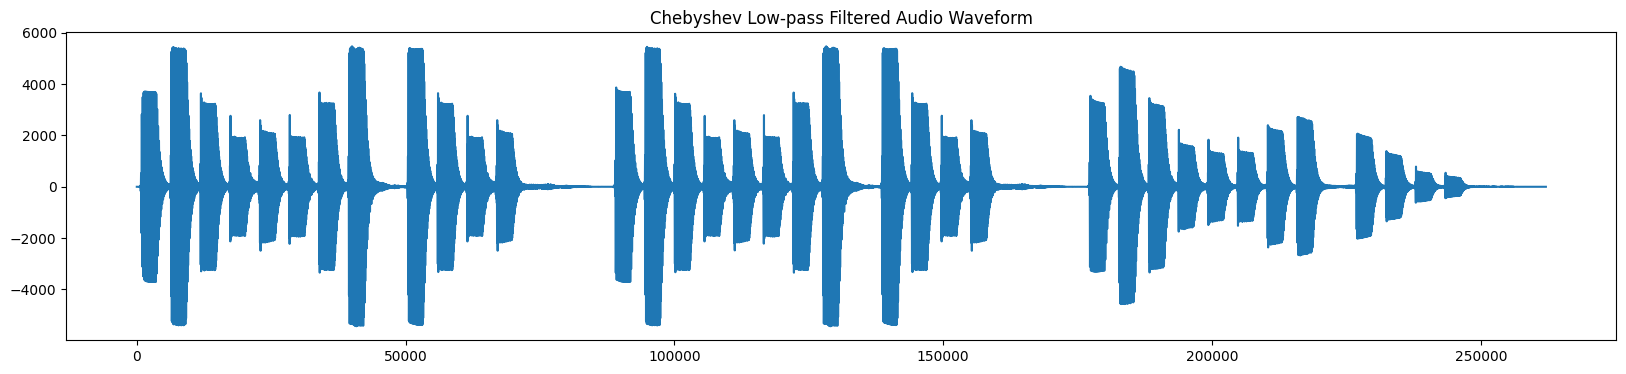

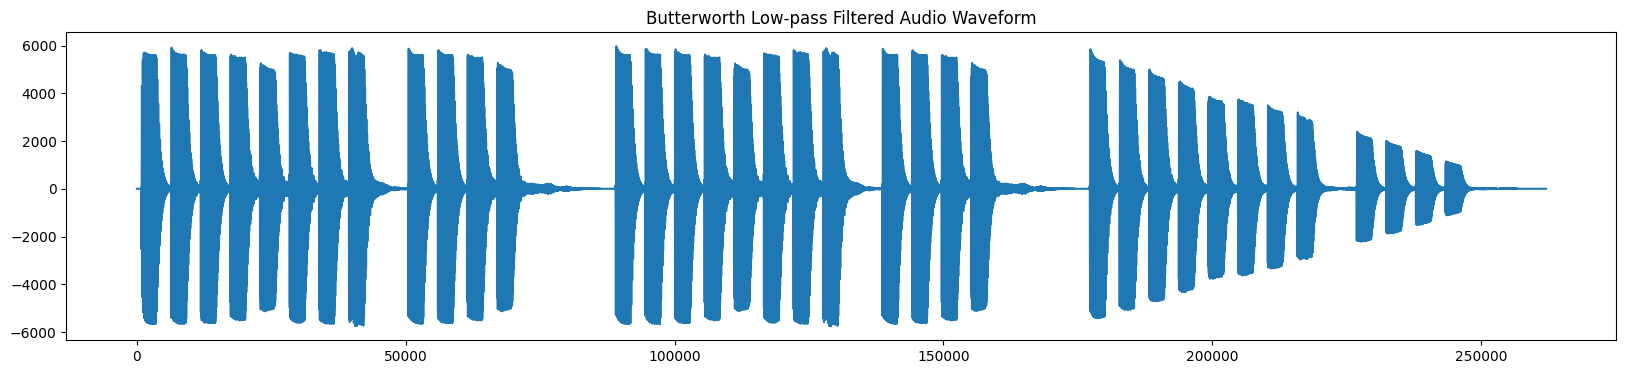

In [4]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal

# 11.1 Найти любой wav файл c музыкальной дорожкой
filename = 'sound1.wav'

# 11.2 Загрузить в блокнот. Построить визуализацию
sample_rate, data = wavfile.read(filename)
# Преобразование стерео в моно
if len(data.shape) > 1:
    data = np.mean(data, axis=1)

plt.figure(figsize=(20, 4))
plt.plot(data)
plt.title('Original Audio Waveform')
plt.show()

# 11.3 Применить фильтрацию Фурье для НЧ, ФЧ фильтров, полосовой фильтр, полосо-заградительный фильтр.
# НЧ фильтр
b, a = signal.butter(5, 1000/(sample_rate/2), btype='low') # НЧ фильтр с частотой среза 1000 Гц
low_passed = signal.lfilter(b, a, data)

# ФЧ фильтр
b, a = signal.butter(5, 1000/(sample_rate/2), btype='high') # ФЧ фильтр с частотой среза 1000 Гц
high_passed = signal.lfilter(b, a, data)

# Полосовой фильтр
b, a = signal.butter(5, [300/(sample_rate/2), 3000/(sample_rate/2)], btype='band') # Полосовой фильтр с частотами среза 300 и 3000 Гц
band_passed = signal.lfilter(b, a, data)

# Полосо-заградительный фильтр
b, a = signal.butter(5, [300/(sample_rate/2), 3000/(sample_rate/2)], btype='bandstop') # Полосо-заградительный фильтр с частотами среза 300 и 3000 Гц
band_stopped = signal.lfilter(b, a, data)

# 11.4 Применить экспотенциальное сглаживание, двойное экспотенциальное, тройное экспотенциальное сглаживание
# Экспоненциальное сглаживание
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

smoothed = exponential_smoothing(data, 0.05)

# Двойное экспоненциальное сглаживание
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

double_smoothed = double_exponential_smoothing(data, 0.05, 0.05)

# Тройное экспоненциальное сглаживание
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # вычисляем сезонные средние
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # вычисляем начальные значения
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # инициализируем значения компонент
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # прогнозируем
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

triple_smoothed = triple_exponential_smoothing(data, 12, 0.716, 0.029, 0.993, 24)

# 11.5 Разобраться в преобразовании Лапласа. Отфильтровать сигнал с помощью фильтра Чебышева (НЧ, ФЧ фильтров, полосовой фильтр, полосо-заградительный фильтр) и Баттерворта.
# Фильтр Чебышева
b, a = signal.cheby1(4, 5, 1000/(sample_rate/2), btype='low') # НЧ фильтр Чебышева с частотой среза 1000 Гц
cheby_low_passed = signal.filtfilt(b, a, data)

# Фильтр Баттерворта
b, a = signal.butter(4, 1000/(sample_rate/2), btype='low') # НЧ фильтр Баттерворта с частотой среза 1000 Гц
butter_low_passed = signal.filtfilt(b, a, data)

# 11.6 Не забываем про визуализацию.
# Визуализация отфильтрованных сигналов
plt.figure(figsize=(20, 4))
plt.plot(low_passed)
plt.title('Low-pass Filtered Audio Waveform')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(high_passed)
plt.title('High-pass Filtered Audio Waveform')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(band_passed)
plt.title('Band-pass Filtered Audio Waveform')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(band_stopped)
plt.title('Band-stop Filtered Audio Waveform')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(smoothed)
plt.title('Exponentially Smoothed Audio Waveform')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(double_smoothed)
plt.title('Double Exponentially Smoothed Audio Waveform')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(triple_smoothed)
plt.title('Triple Exponentially Smoothed Audio Waveform')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(cheby_low_passed)
plt.title('Chebyshev Low-pass Filtered Audio Waveform')
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(butter_low_passed)
plt.title('Butterworth Low-pass Filtered Audio Waveform')
plt.show()